In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.impute import SimpleImputer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [3]:

# Load data
df = pd.read_csv("../../holly_extended.csv")
df

,userId,participant,sex,clinicalStatus,age,MoCA,MoCA5,education,SoF,Craft_21_Immeadiate_Score,Craft_21_Delayed_Score,BCFC_Immeadiate,BCFC_Recall,Total_Animals_Named,Total_Vegetables_Named,MINT_Total_Score,Verbal_F_words,Verbal_L_words
0,69409,p19,F,HC,72,29,3,18,0.370829,29.0,22.0,16.0,10.0,21.0,24.0,32.0,17.0,21.0
1,69410,p01,F,HC,58,30,5,18,0.362003,17.0,16.0,15.0,10.0,29.0,16.0,28.0,14.0,8.0
2,69411,p02,M,MCI,75,23,0,18,0.436298,15.0,3.0,17.0,5.0,28.0,9.0,32.0,17.0,15.0
3,69414,p04,F,HC,72,30,5,18,0.332331,26.0,25.0,NaN,NaN,15.0,15.0,NaN,17.0,14.0
4,69415,p05,M,MCI,67,21,2,14,0.440252,13.0,10.0,14.0,8.0,22.0,15.0,32.0,8.0,9.0
5,69417,p06,M,MCI,73,26,2,17,0.391579,32.0,30.0,16.0,16.0,26.0,19.0,31.0,15.0,18.0
6,69418,p07,M,HC,70,26,4,20,0.392315,10.0,13.0,16.0,9.0,7.0,7.0,28.0,18.0,18.0
7,69419,p08,F,HC,57,30,5,18,0.359259,25.0,27.0,16.0,12.0,22.0,17.0,32.0,16.0,20.0
8,69420,p20,M,HC,73,28,3,20,0.361043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,69421,p12,M,MCI,68,21,0,18,0.387739,9.0,3.0,10.0,2.0,18.0,11.0,31.0,19.0,18.0


Correct data

In [5]:
df['sex'] = df['sex'].str.strip().str.lower()
df['diagnosis'] = df['clinicalStatus'].str.strip().str.lower()

# Define robust mappings
sex_map = {'m': 0, 'male': 0, 'f': 1, 'female': 1}
diagnosis_map = {'hc': 0, 'healthy': 0, 'mci': 1}

# Map strings to integers with .map()
df['sex'] = df['sex'].map(sex_map)
df['diagnosis'] = df['diagnosis'].map(diagnosis_map)

# Feature selection and scaling
X = df[['age', 'sex', 'MoCA', 'SoF']].values
y = df['diagnosis'].values

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


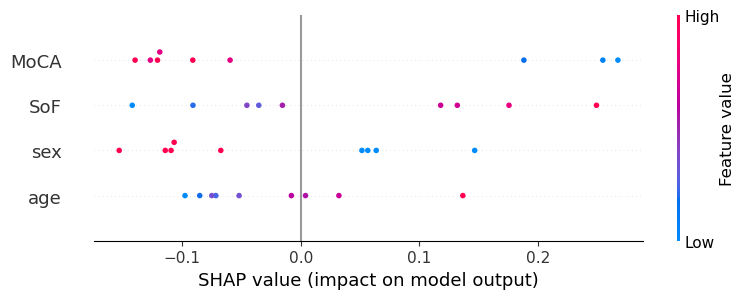

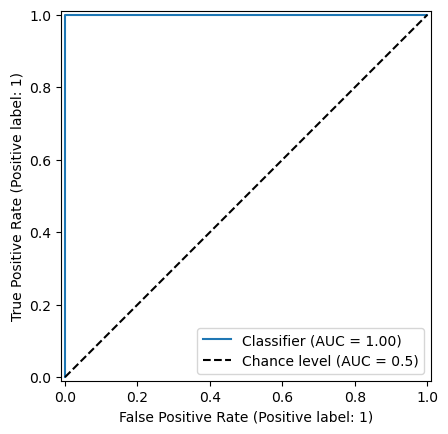

In [6]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Dense(16, activation='relu', input_shape=(4,)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Evaluate with ROC
y_scores = model.predict(X_test).ravel()
#fpr, tpr, _ = roc_curve(y_test, y_scores)
#roc_auc = auc(fpr, tpr)


# SHAP explainability
explainer = shap.Explainer(model, X_train[:20])
shap_values = explainer(X_test[:10])

shap.summary_plot(shap_values, X_test[:10], feature_names=['age', 'sex', 'MoCA', 'SoF'])

fig, ax = plt.subplots(1)
RocCurveDisplay.from_predictions(y_test, y_scores, 
                                 ax=ax, 
                                 pos_label=None, plot_chance_level=True)
plt.show()

# Autoencoders

In [8]:

# Load the data
df = pd.read_csv("../../holly_extended.csv")

df['sex'] = df['sex'].str.strip().str.lower()

# Define robust mappings
sex_map = {'m': 0, 'male': 0, 'f': 1, 'female': 1}

# Map strings to integers with .map()
df['sex'] = df['sex'].map(sex_map)

# Separate input features
features = ['age', 'sex', 'MoCA', 'Craft_21_Delayed_Score',	'BCFC_Immeadiate']
X = df[features].copy()

# 1. Pre-impute with mean (to allow training)
mean_imputer = SimpleImputer(strategy='mean')
X_imputed = mean_imputer.fit_transform(X)

# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3. Build autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 3  # compression

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# 4. Train autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=8, verbose=0)

# 5. Impute missing data using the trained autoencoder
# Mask original rows with missing values
mask_missing = X.isnull().any(axis=1)

# Scale the mean-imputed data again
X_imputed_scaled = scaler.transform(mean_imputer.transform(X))

# Predict (reconstruct) from the autoencoder
X_reconstructed = autoencoder.predict(X_imputed_scaled)

# Inverse transform to return to original scale
X_reconstructed_unscaled = scaler.inverse_transform(X_reconstructed)

# Replace missing entries in original df with reconstructed values
X_filled = X.copy()
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if pd.isnull(X.iloc[i, j]):
            X_filled.iat[i, j] = X_reconstructed_unscaled[i, j]

# Final filled DataFrame
df_imputed = df.copy()
df_imputed[features] = X_filled

# Save or display
print(df_imputed.head())


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
   userId participant  sex clinicalStatus  age  MoCA  MoCA5  education  \
0   69409         p19    1             HC   72    29      3         18   
1   69410         p01    1             HC   58    30      5         18   
2   69411         p02    0            MCI   75    23      0         18   
3   69414         p04    1             HC   72    30      5         18   
4   69415         p05    0            MCI   67    21      2         14   

        SoF  Craft_21_Immeadiate_Score  Craft_21_Delayed_Score  \
0  0.370829                       29.0                    22.0   
1  0.362003                       17.0                    16.0   
2  0.436298                       15.0                     3.0   
3  0.332331                       26.0                    25.0   
4  0.440252                       13.0                    10.0   

   BCFC_Immeadiate  BCFC_Recall  Total_Animals_Named  Total_Vegetables_Named  \
0        16.000000         10.0          

# Convolutional Networks

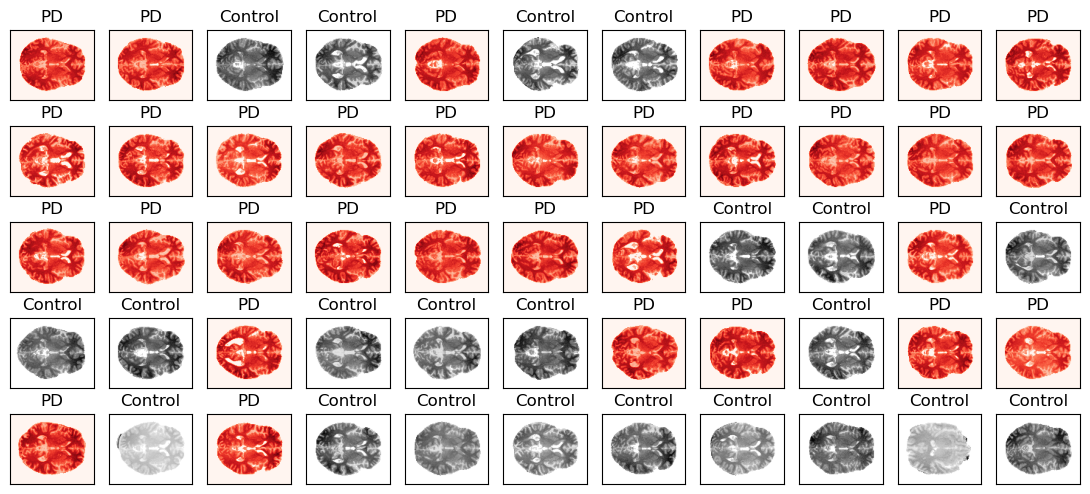

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3601 - loss: 97.2885 - val_accuracy: 0.7143 - val_loss: 20.9721
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5595 - loss: 28.1582 - val_accuracy: 0.7143 - val_loss: 1.6309
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5763 - loss: 15.3132 - val_accuracy: 0.2857 - val_loss: 2.0187
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5810 - loss: 5.0908 - val_accuracy: 0.7143 - val_loss: 1.9451
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5913 - loss: 2.8853 - val_accuracy: 0.7143 - val_loss: 1.5129
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7145 - loss: 1.3564 - val_accuracy: 0.5714 - val_loss: 0.5469
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7254 - loss: 0.5137 - val_accuracy: 0.5714 - val_loss: 0.5964
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7445 - loss: 0.4391 - val_accuracy: 0.7143 - val_loss: 0.5395
Epoch 9

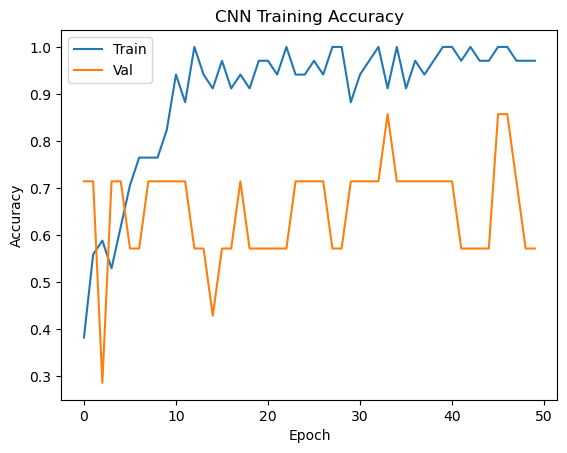

In [10]:
X = np.load('../../pd_images.npy')  # Shape: (N, 96, 114)
y = np.load('../../pd_labels.npy')        # Shape: (N,)

# Display data
fig, axes = plt.subplots(5, 11, figsize = (11, 5))
axs = axes.flatten()
for i in range(X.shape[0]):
    cmap = "Reds"
    if y[i] == 0:
        cmap = "Grays"
    axs[i].imshow(X[i,:,:], cmap=cmap)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    if y[i] == 1:
        axs[i].set_title("PD")
    else:
        axs[i].set_title("Control")

fig.tight_layout()
plt.show()
#plt.matshow(X[i,:,:])
                
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define CNN model
model = Sequential([
    Conv2D(16, (6, 6), activation='relu', input_shape=(96, 114, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.15, verbose=1)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training curves
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
